# Make Figures for second section of Results

"3.2 A multidecadal shift in SAMW volume"

 - Figure 2
 - Supplementary Figures ...

## imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask as da
from dask.diagnostics import ProgressBar
import gsw as gsw

# plotting packages
#import seaborn as sb
#sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import xesmf as xe 

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)

# activate the dask progress bar
ProgressBar().register()

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


## load in the model data

In [2]:

age = xr.open_dataset('JRA55_pic_1m_Age_1958-2022.nc')['Age']
temp = xr.open_dataset('JRA55_pic_1m_ts_1958-2022.nc')['thetao']
salt = xr.open_dataset('JRA55_pic_1m_ts_1958-2022.nc')['so']

deps = age['deptht']

# grab the volume of grid cells on the tracer grid
data = xr.open_dataset('ORCA2.0.full_grid.nc')
lons = data['lon']
lats = data['lat']
lons_bnds = data['bounds_lon']
lats_bnds = data['bounds_lat']

data = xr.open_dataset('ORCA2_xyz_grid_T.nc')
dxt = data['e1t']
dyt = data['e2t']
dzt = data['e3t']
volume = dxt * dyt * dzt
area = dxt * dyt

data.close()



## rename some dimensions/coordinates

In [3]:

month = np.arange(1,13,1)
year = np.arange(1958.5,2022.51,1)

age = age.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
temp = temp.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
salt = salt.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
tempSEp = tempSEp.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
saltSEp = saltSEp.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
tempSWp = tempSWp.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
saltSWp = saltSWp.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
volume = volume.rename({"deptht":"depth"})
temp



<xarray.DataArray 'thetao' (year: 65, month: 12, depth: 31, y: 149, x: 182)> Size: 3GB
[655713240 values with dtype=float32]
Coordinates:
  * depth          (depth) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
    lat            (y, x) float32 108kB ...
    lon            (y, x) float32 108kB ...
    time_centered  (month) object 96B ...
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * year           (year) float64 520B 1.958e+03 1.96e+03 ... 2.022e+03
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

## chunk the dataset

In [4]:
chunky = {'year':1, 'month':1, 'depth':31, 'y':149, 'x':182}
age = age.chunk(chunks=chunky).drop_vars('time_centered')
temp = temp.chunk(chunks=chunky).drop_vars('time_centered')
salt = salt.chunk(chunks=chunky).drop_vars('time_centered')
tempSEp = tempSEp.chunk(chunks=chunky).drop_vars('time_centered')
saltSEp = saltSEp.chunk(chunks=chunky).drop_vars('time_centered')
tempSWp = tempSWp.chunk(chunks=chunky).drop_vars('time_centered')
saltSWp = saltSWp.chunk(chunks=chunky).drop_vars('time_centered')
temp

<xarray.DataArray 'thetao' (year: 65, month: 12, depth: 31, y: 149, x: 182)> Size: 3GB
dask.array<xarray-<this-array>, shape=(65, 12, 31, 149, 182), dtype=float32, chunksize=(1, 1, 31, 149, 182), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
    lat      (y, x) float32 108kB dask.array<chunksize=(149, 182), meta=np.ndarray>
    lon      (y, x) float32 108kB dask.array<chunksize=(149, 182), meta=np.ndarray>
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) float64 520B 1.958e+03 1.96e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

## make new depth to regrid to and also the new volumes of the cells

100 100


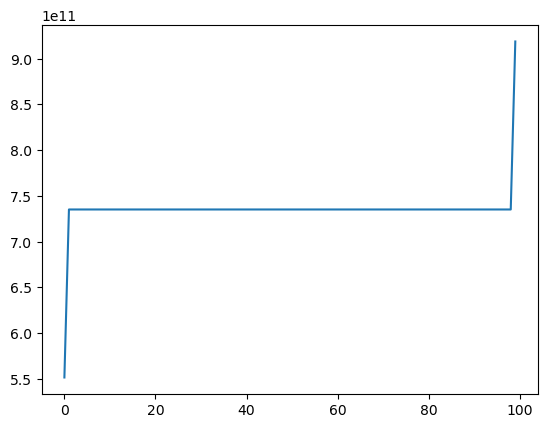

In [5]:
new_depth = np.arange(5,2001,20)
new_depth_thick = np.arange(-5,2001,20)
new_depth_thick[0] = 0; new_depth_thick[-1] = 2000; 
new_depth_thick = np.diff(new_depth_thick)
print(len(new_depth), len(new_depth_thick))

new_depth_thick = new_depth_thick[:, np.newaxis, np.newaxis]
new_depth_thick = np.broadcast_to(new_depth_thick, (100,149,182))

dep_thick = xr.DataArray(
    new_depth_thick,
    dims=["depth", "y", "x"],
    coords={"depth": new_depth, "x":area.x, "y":area.y}
    )

vol = area.expand_dims({"depth": dep_thick.depth})
vol = vol * dep_thick

plt.figure()
plt.plot(vol.isel(x=40, y=49))


## regrid the depth coordinate to finer resolution in the upper 2000 metres

[########################################] | 100% Completed | 101.58 ms
[########################################] | 100% Completed | 100.88 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 101.24 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 101.64 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.92 ms
[########################################] | 100% Completed | 101.25 ms
[########################################] | 100% Completed | 100.92 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.88 ms
[########################################] | 100% Completed | 302.40 ms
[########################################] | 100% Completed | 60

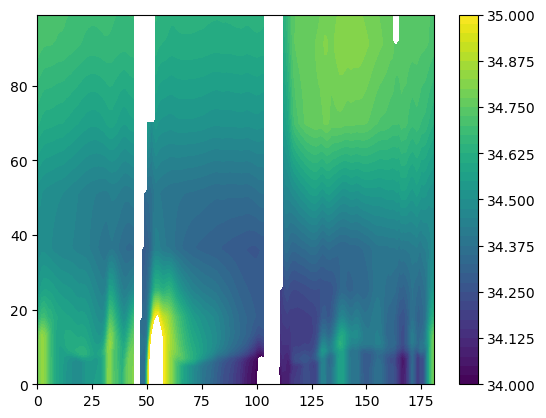

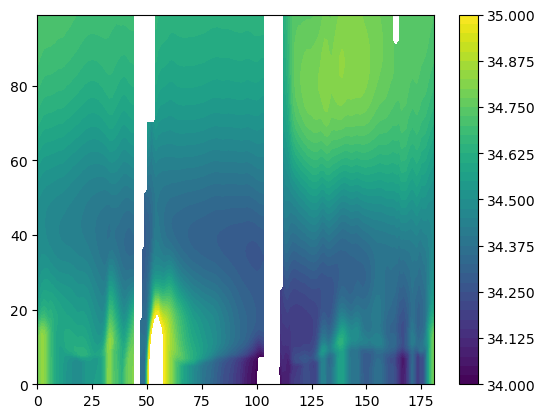

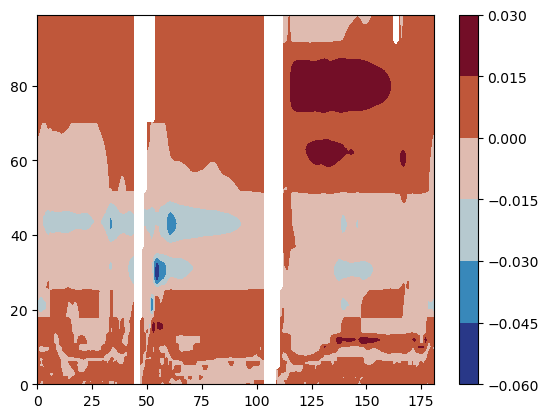

In [6]:
%%time

temp_lin = temp.where(salt>0.0, other=np.nan).isel(depth=slice(0,25)).interp(depth=new_depth, method='linear')
salt_lin = salt.where(salt>0.0, other=np.nan).isel(depth=slice(0,25)).interp(depth=new_depth, method='linear')

temp = temp.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')
salt = salt.where(salt>0.0, other=np.nan).interpolate_na(dim='x', method='linear').interpolate_na(dim='y', method='linear').interpolate_na(dim='depth', method='linear')

temp = temp.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))
salt = salt.where(~np.isnan(salt),other=0.0).isel(depth=slice(0,25))

temp_cub = temp.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)
salt_cub = salt.interp(depth=new_depth, method='cubic').where(salt_lin>0.0, other=np.nan)

plt.figure()
p1 = plt.contourf(salt_lin.isel(year=1,month=7,y=40), levels=np.arange(34.0,35.01,0.025))
plt.colorbar(p1)

plt.figure()
p1 = plt.contourf(salt_cub.isel(year=1,month=7,y=40), levels=np.arange(34.0,35.01,0.025))
plt.colorbar(p1)

plt.figure()
p1 = plt.contourf((salt_cub-salt_lin).isel(year=1,month=7,y=40), cmap=cmo.balance)
plt.colorbar(p1)


## calculate the density

In [7]:
rho0_lin = gsw.density.sigma0(salt_lin, temp_lin)
rho0_cub = gsw.density.sigma0(salt_cub, temp_cub)

# mask rho0 where there are zeros
rho0_lin = rho0_lin.where(rho0_lin > 0.0, other=np.nan)
rho0_cub = rho0_cub.where(rho0_cub > 0.0, other=np.nan)


[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 101.20 ms
[########################################] | 100% Completed | 100.73 ms
[########################################] | 100% Completed | 100.85 ms


## vertical gradient in potential density

In [8]:
dpdz_lin = rho0_lin.differentiate('depth')
dpdz_cub = rho0_cub.differentiate('depth')


## calculate the "thermostad", the change in depth per degree C


-101.99998 -44.646076
[########################################] | 100% Completed | 201.73 ms
[########################################] | 100% Completed | 2.38 sms
[########################################] | 100% Completed | 101.56 ms
[########################################] | 100% Completed | 1.91 sms


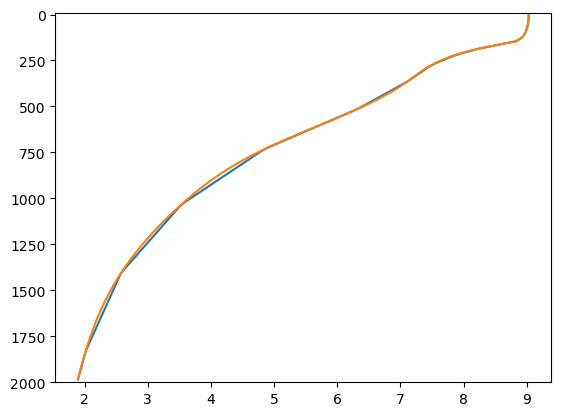

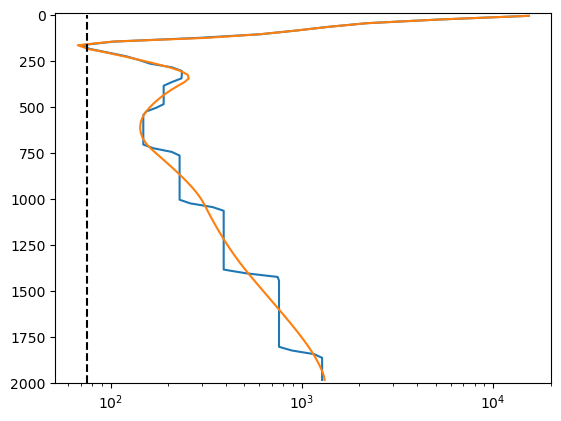

In [9]:

dtdz_lin = temp_lin.differentiate('depth')
dzdt_lin = np.abs(1.0/dtdz_lin)

dtdz_cub = temp_cub.differentiate('depth')
dzdt_cub = np.abs(1.0/dtdz_cub)

xx = 90; yy = 40
print(temp_lin.coords['lon'].isel(x=xx,y=yy).values, temp_lin.coords['lat'].isel(x=xx,y=yy).values)

plt.figure()
plt.plot(temp_lin.isel(year=0,month=7,x=xx,y=yy), temp_lin.coords['depth'])
plt.plot(temp_cub.isel(year=0,month=7,x=xx,y=yy), temp_cub.coords['depth'])
plt.ylim(2000,-10)

plt.figure()
plt.plot(np.abs(dzdt_lin.isel(year=0,month=7,x=xx,y=yy)), dtdz_lin.coords['depth'])
plt.plot(np.abs(dzdt_cub.isel(year=0,month=7,x=xx,y=yy)), dtdz_cub.coords['depth'])
plt.ylim(2000,-10)
plt.plot((75,75), (2000,0), 'k--')
plt.xscale('log')



## get the isopycnal bounds and select grid cells belonging to SAMW

In [10]:
### set bounds for SAMW
samw_rho0_bnds = np.array([26.5, 27.1])
samw_lati_bnds = np.array([-90., -20.])
samw_dzdt_bnds = np.array([75.0])
### set bounds for AAIW
aaiw_lati_bnds = np.array([-90., -20.])
aaiw_rho0_bnds = np.array([27.1, 27.5])



In [11]:

samw_lin = rho0_lin*0 + 1.0
samw_lin = samw_lin.where(rho0_lin > samw_rho0_bnds[0], other=0.0).where(rho0_lin < samw_rho0_bnds[1], other=0.0)
samw_lin = samw_lin.where(samw_lin.coords['lat'] > samw_lati_bnds[0], other=0.0).where(samw_lin.coords['lat'] < samw_lati_bnds[1], other=0.0)
samw_lin = samw_lin.where(dzdt_lin > samw_dzdt_bnds[0], other=0.0)
samw_lin_volume = (samw_lin * vol).drop_vars(['nav_lon', 'nav_lat', 'time_centered'])    # m3

samw_cub = rho0_cub*0 + 1.0
samw_cub = samw_cub.where(rho0_cub > samw_rho0_bnds[0], other=0.0).where(rho0_cub < samw_rho0_bnds[1], other=0.0)
samw_cub = samw_cub.where(samw_cub.coords['lat'] > samw_lati_bnds[0], other=0.0).where(samw_cub.coords['lat'] < samw_lati_bnds[1], other=0.0)
samw_cub = samw_cub.where(dzdt_cub > samw_dzdt_bnds[0], other=0.0)
samw_cub_volume = (samw_cub * vol).drop_vars(['nav_lon', 'nav_lat', 'time_centered'])    # m3

aaiw_lin = rho0_lin*0 + 1.0
aaiw_lin = aaiw_lin.where(rho0_lin > aaiw_rho0_bnds[0], other=0.0).where(rho0_lin < aaiw_rho0_bnds[1], other=0.0)
aaiw_lin = aaiw_lin.where(aaiw_lin.coords['lat'] > aaiw_lati_bnds[0], other=0.0).where(aaiw_lin.coords['lat'] < aaiw_lati_bnds[1], other=0.0)
aaiw_lin_volume = (aaiw_lin * vol).drop_vars(['nav_lon', 'nav_lat', 'time_centered'])    # m3

aaiw_cub = rho0_cub*0 + 1.0
aaiw_cub = aaiw_cub.where(rho0_cub > aaiw_rho0_bnds[0], other=0.0).where(rho0_cub < aaiw_rho0_bnds[1], other=0.0)
aaiw_cub = aaiw_cub.where(aaiw_cub.coords['lat'] > aaiw_lati_bnds[0], other=0.0).where(aaiw_cub.coords['lat'] < aaiw_lati_bnds[1], other=0.0)
aaiw_cub_volume = (aaiw_cub * vol).drop_vars(['nav_lon', 'nav_lat', 'time_centered'])    # m3



## rearrange the time axis to one dimension, rather than two split by month and year

In [12]:
from datetime import datetime, timedelta
start_date = datetime(1958, 1, 1)
end_date = datetime(2022, 12, 31)
time = pd.date_range(start=start_date, end=end_date, freq="MS") + pd.DateOffset(days=14)

samw_lin_volume = samw_lin_volume.stack(time=("year", "month")).drop_vars(['year', 'month']).assign_coords(time=time).chunk({"depth":-1, "y":-1, "x":-1, "time":1})
aaiw_lin_volume = aaiw_lin_volume.stack(time=("year", "month")).drop_vars(['year', 'month']).assign_coords(time=time).chunk({"depth":-1, "y":-1, "x":-1, "time":1})
rho0_lin = rho0_lin.stack(time=("year", "month")).drop_vars(['year', 'month']).assign_coords(time=time).chunk({"depth":-1, "y":-1, "x":-1, "time":1})

samw_cub_volume = samw_cub_volume.stack(time=("year", "month")).drop_vars(['year', 'month']).assign_coords(time=time).chunk({"depth":-1, "y":-1, "x":-1, "time":1})
aaiw_cub_volume = aaiw_cub_volume.stack(time=("year", "month")).drop_vars(['year', 'month']).assign_coords(time=time).chunk({"depth":-1, "y":-1, "x":-1, "time":1})
rho0_cub = rho0_cub.stack(time=("year", "month")).drop_vars(['year', 'month']).assign_coords(time=time).chunk({"depth":-1, "y":-1, "x":-1, "time":1})


## separate into basins


### SAMW

[########################################] | 100% Completed | 29.49 ss
[########################################] | 100% Completed | 29.78 ss
[########################################] | 100% Completed | 30.26 ss


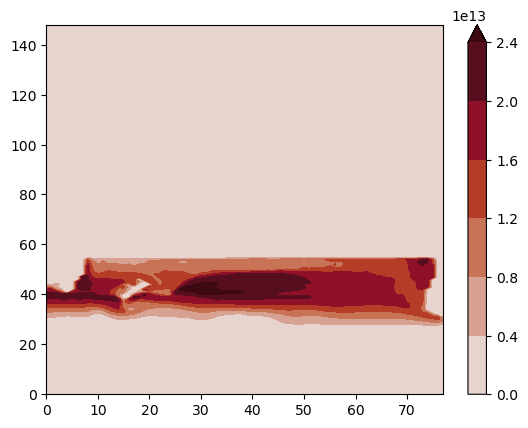

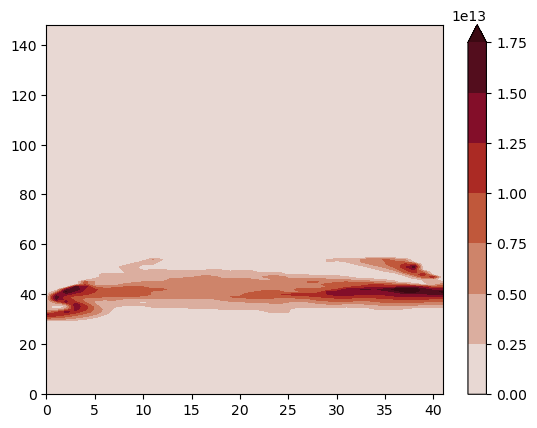

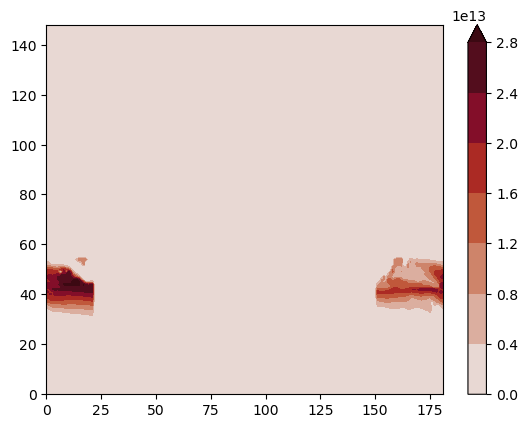

In [13]:

samw_lin_volume_pac = samw_lin_volume.isel(x=slice(30,108))
samw_lin_volume_atl = samw_lin_volume.isel(x=slice(110,152))
samw_lin_volume_ind = samw_lin_volume.where(samw_lin_volume.coords['lon'] < 120.0, other = 0.0).where(samw_lin_volume.coords['lon'] > 20.0, other = 0.0)

samw_cub_volume_pac = samw_cub_volume.isel(x=slice(30,108))
samw_cub_volume_atl = samw_cub_volume.isel(x=slice(110,152))
samw_cub_volume_ind = samw_cub_volume.where(samw_cub_volume.coords['lon'] < 120.0, other = 0.0).where(samw_cub_volume.coords['lon'] > 20.0, other = 0.0)

plt.figure()
p1 = plt.contourf(samw_cub_volume_pac.isel(time=7).sum(dim='depth'), cmap=cmo.amp, extend='max')
plt.colorbar(p1)

plt.figure()
p1 = plt.contourf(samw_cub_volume_atl.isel(time=7).sum(dim='depth'), cmap=cmo.amp, extend='max')
plt.colorbar(p1)

plt.figure()
p1 = plt.contourf(samw_cub_volume_ind.isel(time=7).sum(dim='depth'), cmap=cmo.amp, extend='max')
plt.colorbar(p1)


### AAIW

[########################################] | 100% Completed | 511.47 ms
[########################################] | 100% Completed | 610.84 ms
[########################################] | 100% Completed | 509.33 ms


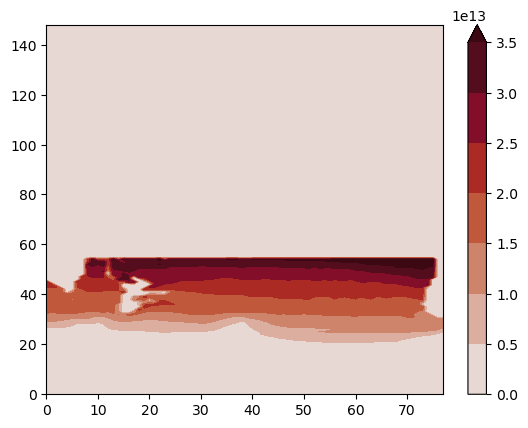

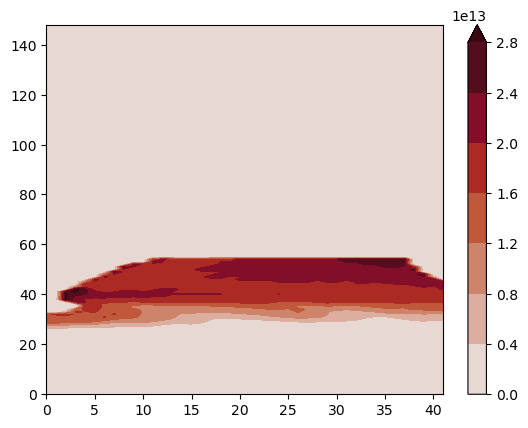

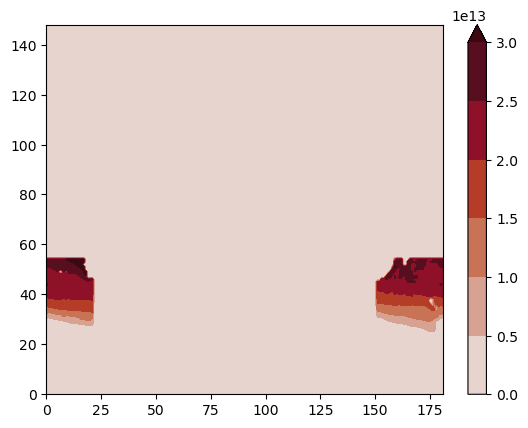

In [14]:
aaiw_lin_volume_pac = aaiw_lin_volume.isel(x=slice(30,108))
aaiw_lin_volume_atl = aaiw_lin_volume.isel(x=slice(110,152))
aaiw_lin_volume_ind = aaiw_lin_volume.where(aaiw_lin_volume.coords['lon'] < 120.0, other = 0.0).where(aaiw_lin_volume.coords['lon'] > 20.0, other = 0.0)

aaiw_cub_volume_pac = aaiw_cub_volume.isel(x=slice(30,108))
aaiw_cub_volume_atl = aaiw_cub_volume.isel(x=slice(110,152))
aaiw_cub_volume_ind = aaiw_cub_volume.where(aaiw_cub_volume.coords['lon'] < 120.0, other = 0.0).where(aaiw_cub_volume.coords['lon'] > 20.0, other = 0.0)

plt.figure()
p1 = plt.contourf(aaiw_lin_volume_pac.isel(time=7).sum(dim='depth'), cmap=cmo.amp, extend='max')
plt.colorbar(p1)

plt.figure()
p1 = plt.contourf(aaiw_lin_volume_atl.isel(time=7).sum(dim='depth'), cmap=cmo.amp, extend='max')
plt.colorbar(p1)

plt.figure()
p1 = plt.contourf(aaiw_lin_volume_ind.isel(time=7).sum(dim='depth'), cmap=cmo.amp, extend='max')
plt.colorbar(p1)

## Make timeseries figure of integrated SAMW volume

### SKIP THIS NOW AND LOAD IN THE ALREADY CALCULATED VALUES FROM THE PREVIOUSLY SAVED NETCDF

In [20]:
%%time

### Calculate the integrated volume of SAMW using the cubic spline vertical interpolation

samw_volume = samw_cub_volume.isel(y=slice(0,72))
samw_volume_pac = samw_cub_volume_pac.isel(y=slice(0,72))
samw_volume_ind = samw_cub_volume_ind.isel(y=slice(0,72))
samw_volume_atl = samw_cub_volume_atl.isel(y=slice(0,72))

samw_volume_sum = samw_volume.sum(dim=['x','y','depth']).compute() * 1e-12
samw_volume_pac_sum = samw_volume_pac.sum(dim=['x','y','depth']).compute() * 1e-12
samw_volume_ind_sum = samw_volume_ind.sum(dim=['x','y','depth']).compute() * 1e-12
samw_volume_atl_sum = samw_volume_atl.sum(dim=['x','y','depth']).compute() * 1e-12


[################################        ] | 80% Completed | 18m 1sss
[################################        ] | 80% Completed | 18m 2s
[################################        ] | 80% Completed | 18m 2s


KeyboardInterrupt: 

In [144]:
samw_volume_sum

<xarray.DataArray (time: 780)> Size: 6kB
array([41928.97678741, 41501.47390397, 41601.10087274, 42191.80915586,
       42728.18190953, 43242.82784363, 43951.32921962, 44608.322644  ,
       44701.50436598, 44562.20355903, 44109.57064009, 43344.16865536,
       42268.62588416, 41706.31020892, 41880.89477557, 42502.76534627,
       42906.9943938 , 43302.83539365, 43840.42065285, 44592.75696439,
       44799.79196548, 44678.80457473, 44476.21177198, 43813.35909921,
       42360.94638177, 41939.37895649, 42171.62208787, 42620.45562015,
       43134.2886217 , 43485.09525474, 44037.17014031, 44716.75738741,
       44941.9701649 , 44797.802671  , 44383.81250702, 43510.4007454 ,
       42190.16760848, 41771.63880903, 42024.75036132, 42456.24518434,
       42940.63076531, 43432.02390916, 43970.91988184, 44473.05188527,
       44738.03939867, 44659.93979576, 44367.81821053, 43601.80298222,
       42429.7593174 , 42037.20504776, 42178.94549382, 42655.16021523,
       43090.18664213, 43502.47898108, 43986.82924107, 44467.41999025,
       44726.69554993, 44538.8844903 , 44186.83625976, 43342.31761227,
       42071.73127545, 41593.67167556, 41816.01312053, 42319.59545334,
       42902.48000667, 43297.02295141, 43784.73173756, 44471.62290785,
       44948.25599691, 44741.7212912 , 44468.02160942, 43794.65943785,
       42101.29703286, 41781.39649722, 42021.81808742, 42505.52707688,
       43092.43106362, 43673.53574829, 44291.74457325, 44870.63606426,
...
       45035.83371402, 45546.96016785, 46015.2620812 , 46515.01704913,
       46823.13217177, 46769.66087591, 46478.27869008, 45707.13439143,
       44468.60915308, 44081.71518795, 44131.13178161, 44583.51874654,
       45199.43283669, 45689.53900362, 46131.24358031, 46415.27333519,
       46566.06732838, 46384.26039343, 46104.77467266, 45377.61002783,
       44279.92899167, 43949.89546423, 43934.44960026, 44301.38032271,
       44614.33399533, 45057.16247679, 45537.78344398, 46189.76355575,
       46388.52634257, 46262.12962005, 45980.4888697 , 45336.43450481,
       44455.8064574 , 44002.89889227, 43998.16222165, 44338.97828927,
       44658.15263018, 44981.97522037, 45505.70670872, 46064.23738103,
       46540.95330565, 46529.24524482, 46155.82015272, 45126.90943439,
       43933.04282079, 43533.3077053 , 43555.96711475, 44073.54058054,
       44517.62159242, 44971.12452866, 45527.21670591, 46146.33658174,
       46557.10374417, 46520.65175089, 46202.59200889, 45603.58264466,
       44695.29638165, 44462.32506329, 44438.36761585, 44687.39914865,
       44871.60949835, 45166.5652246 , 45593.79520201, 46041.15678376,
       46248.9633184 , 46231.43816184, 45838.36561783, 45327.03044773,
       44434.67048653, 44007.26896495, 44060.30999612, 44407.44452634,
       44718.75046171, 45035.99536746, 45618.62734061, 46072.89839998,
       46241.67234553, 46154.38937302, 45872.3207833 , 45138.29633712])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-01-15 1958-02-15 ... 2022-12-15

In [15]:
os.getcwd()

'/expanse/lustre/projects/ciw112/pbuchanan/JRA55'

In [149]:
### save to netcdf

ds = xr.Dataset({
    "volume_global": samw_volume_sum,
    "volume_pacific": samw_volume_pac_sum,
    "volume_atlantic": samw_volume_atl_sum,
    "volume_indian": samw_volume_ind_sum
})
    

#samw_volume_sum.to_netcdf("JRA55_pic_1m_SAMWvolumesum_1958-2022.nc")
#samw_volume_pac_sum.to_netcdf("JRA55_pic_1m_SAMWvolumesum_pacific_1958-2022.nc")
#samw_volume_ind_sum.to_netcdf("JRA55_pic_1m_SAMWvolumesum_indian_1958-2022.nc")
#samw_volume_atl_sum.to_netcdf("JRA55_pic_1m_SAMWvolumesum_atlantic_1958-2022.nc")

ds.to_netcdf("JRA55_pic_1m_SAMWvolumesum_1958-2022.nc")


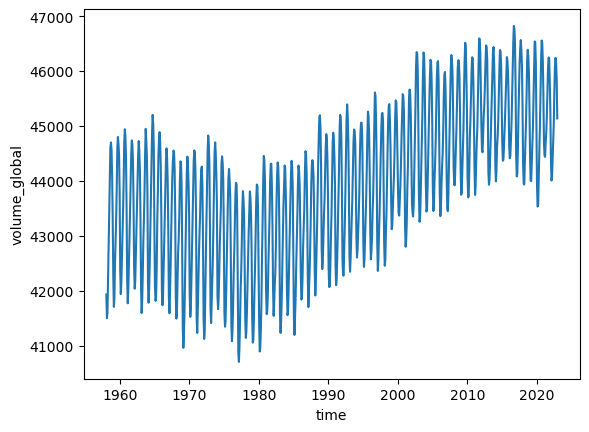

In [16]:
### load if already saved

samw_volume_sum = xr.open_dataset("JRA55_pic_1m_SAMWvolumesum_1958-2022.nc")['volume_global']
samw_volume_pac_sum = xr.open_dataset("JRA55_pic_1m_SAMWvolumesum_1958-2022.nc")['volume_pacific']
samw_volume_atl_sum = xr.open_dataset("JRA55_pic_1m_SAMWvolumesum_1958-2022.nc")['volume_atlantic']
samw_volume_ind_sum = xr.open_dataset("JRA55_pic_1m_SAMWvolumesum_1958-2022.nc")['volume_indian']

samw_volume_sum.plot()

CPU times: user 72.3 ms, sys: 10.9 ms, total: 83.2 ms
Wall time: 81.6 ms


Text(0.015, 0.975, 'd')

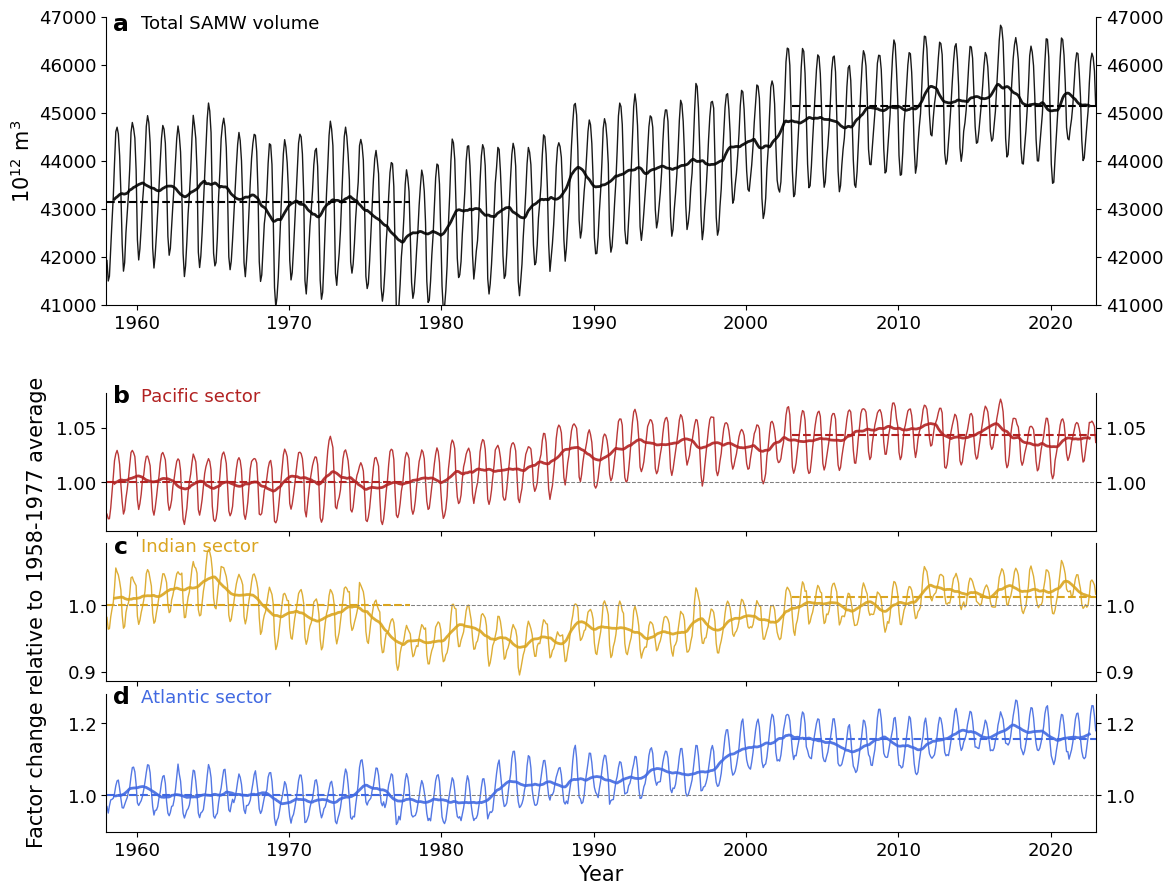

In [18]:
%%time

fstic = 13
fslab = 15
lwid = [1.0, 2.0, 2.0, 2.0]
cols = ['k', 'k']
lsty = ['-', '-']
alfs = 0.9
labs = ['Circumpolar', 'Pacific', 'Indian', 'Atlantic']

fig = plt.figure(figsize=(12,10), facecolor='w')
gs = GridSpec(11,1)

ax1 = plt.subplot(gs[0:4,0])
ax2 = plt.subplot(gs[5:7,0])
ax3 = plt.subplot(gs[7:9,0])
ax4 = plt.subplot(gs[9:11,0])
ax1.tick_params(right=True, labelright=True, labelsize=fstic)
ax2.tick_params(right=True, labelright=True, labelsize=fstic, labelbottom=False)
ax3.tick_params(right=True, labelright=True, labelsize=fstic, labelbottom=False)
ax4.tick_params(right=True, labelright=True, labelsize=fstic)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['top'].set_visible(False)


ax1.plot(time, samw_volume_sum, color=cols[0], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax1.plot(time, samw_volume_sum.rolling(time=12, center=True).mean(), color=cols[1], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1])
ax1.plot(time[0:240], np.ones((240))*samw_volume_sum.isel(time=slice(0,240)).mean(dim='time').values, 'k--')
ax1.plot(time[-240::], np.ones((240))*samw_volume_sum.isel(time=slice(-240,780)).mean(dim='time').values, 'k--')

samw_volume_pac_per = (samw_volume_pac_sum / samw_volume_pac_sum.isel(time=slice(0,240)).mean(dim="time"))
samw_volume_ind_per = (samw_volume_ind_sum / samw_volume_ind_sum.isel(time=slice(0,240)).mean(dim="time"))
samw_volume_atl_per = (samw_volume_atl_sum / samw_volume_atl_sum.isel(time=slice(0,240)).mean(dim="time"))


cols = ['firebrick', 'goldenrod', 'royalblue']
lab = ['Pacific\n(%d 10$^{12}$ m$^{3}$)'%(samw_volume_pac_sum.isel(time=slice(0,240)).mean(dim='time')), \
       'Indian\n(%d 10$^{12}$ m$^{3}$)'%(samw_volume_ind_sum.isel(time=slice(0,240)).mean(dim='time')), \
       'Atlantic\n(%d 10$^{12}$ m$^{3}$)'%(samw_volume_atl_sum.isel(time=slice(0,240)).mean(dim='time'))]

ax2.plot(time, samw_volume_pac_per, color=cols[0], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax3.plot(time, samw_volume_ind_per, color=cols[1], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax4.plot(time, samw_volume_atl_per, color=cols[2], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])

ax2.plot(time, np.ones(len(time))*samw_volume_pac_per.isel(time=slice(0,240)).mean(dim='time').values, color='grey', linewidth=0.75, alpha=1.0, linestyle='--')
ax3.plot(time, np.ones(len(time))*samw_volume_ind_per.isel(time=slice(0,240)).mean(dim='time').values, color='grey', linewidth=0.75, alpha=1.0, linestyle='--')
ax4.plot(time, np.ones(len(time))*samw_volume_atl_per.isel(time=slice(0,240)).mean(dim='time').values, color='grey', linewidth=0.75, alpha=1.0, linestyle='--')

ax2.plot(time, samw_volume_pac_per.rolling(time=12, center=True).mean(), color=cols[0], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[0])
ax3.plot(time, samw_volume_ind_per.rolling(time=12, center=True).mean(), color=cols[1], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[1])
ax4.plot(time, samw_volume_atl_per.rolling(time=12, center=True).mean(), color=cols[2], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[2])

ax2.plot(time[0:240], np.ones((240))*samw_volume_pac_per.isel(time=slice(0,240)).mean(dim='time').values, linestyle='--', color=cols[0])
ax2.plot(time[-240::], np.ones((240))*samw_volume_pac_per.isel(time=slice(-240,780)).mean(dim='time').values, linestyle='--', color=cols[0])
ax3.plot(time[0:240], np.ones((240))*samw_volume_ind_per.isel(time=slice(0,240)).mean(dim='time').values, linestyle='--', color=cols[1])
ax3.plot(time[-240::], np.ones((240))*samw_volume_ind_per.isel(time=slice(-240,780)).mean(dim='time').values, linestyle='--', color=cols[1])
ax4.plot(time[0:240], np.ones((240))*samw_volume_atl_per.isel(time=slice(0,240)).mean(dim='time').values, linestyle='--', color=cols[2])
ax4.plot(time[-240::], np.ones((240))*samw_volume_atl_per.isel(time=slice(-240,780)).mean(dim='time').values, linestyle='--', color=cols[2])

ax1.set_xlim(start_date,end_date)
ax2.set_xlim(start_date,end_date)
ax3.set_xlim(start_date,end_date)
ax4.set_xlim(start_date,end_date)

ax1.set_ylim(41000,47000)
#ax2.set_ylim(0.53,0.6)
#ax3.set_ylim(0.26,0.33)
#ax4.set_ylim(0.09, 0.15)

ax4.set_xlabel("Year", fontsize=fslab)
ax1.set_ylabel("10$^{12}$ m$^{3}$", fontsize=fslab)
#ax2.set_ylabel("Contribution to total", fontsize=fslab)
ax3.set_ylabel("Factor change relative to 1958-1977 average", fontsize=fslab, labelpad=15)
#ax4.set_ylabel("Contribution to total", fontsize=fslab)
#ax2.legend(loc='upper center', frameon=False, fontsize=fstic, ncol=3, bbox_to_anchor=(0.35,0.95))

plt.text(0.035, 0.975,"Total SAMW volume", fontsize=fstic, transform=ax1.transAxes, va='center', ha='left')
plt.text(0.035, 0.975,"Pacific sector", fontsize=fstic, transform=ax2.transAxes, va='center', ha='left', color=cols[0])
plt.text(0.035, 0.975,"Indian sector", fontsize=fstic, transform=ax3.transAxes, va='center', ha='left', color=cols[1])
plt.text(0.035, 0.975,"Atlantic sector", fontsize=fstic, transform=ax4.transAxes, va='center', ha='left', color=cols[2])

plt.subplots_adjust(left=0.1, right=0.925, top=0.925, hspace=0.2)

'''
### determine statistical difference between first and last 20 years
from scipy.stats import wilcoxon
samw_volume_total = samw_volume.isel(y=slice(0,72)).sum(dim=['x','y','depth'])*1e-12
stat_tot, p_tot = wilcoxon(samw_volume_total.isel(time=slice(0,240)).values, 
                           samw_volume_total.isel(time=slice(-240,780)).values)
stat_pac, p_pac = wilcoxon(samw_volume_pac_per.isel(time=slice(0,240)).values, 
                           samw_volume_pac_per.isel(time=slice(-240,780)).values)
stat_ind, p_ind = wilcoxon(samw_volume_ind_per.isel(time=slice(0,240)).values, 
                           samw_volume_ind_per.isel(time=slice(-240,780)).values)
stat_atl, p_atl = wilcoxon(samw_volume_atl_per.isel(time=slice(0,240)).values, 
                           samw_volume_atl_per.isel(time=slice(-240,780)).values)
'''

xx = 0.015; yy = 0.975
plt.text(xx,yy,'a', fontsize=fslab+2, fontweight='bold', va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, fontweight='bold', va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontsize=fslab+2, fontweight='bold', va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontsize=fslab+2, fontweight='bold', va='center', ha='center', transform=ax4.transAxes)


In [154]:
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_cub_volume_timeseries.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_cub_volume_timeseries.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_cub_volume_timeseries_trans.png', dpi=300, bbox_inches='tight', transparent=True)


## print out the changes in volume globally and the factor changes in the different basins


In [19]:
print("SAMW volume at start of simulation =", samw_volume_sum.isel(time=slice(0,240)).mean(dim='time').values)
print("SAMW volume at end of simulation =", samw_volume_sum.isel(time=slice(-240,780)).mean(dim='time').values)
print(lab[0])
print("Factor change in Pacific =", samw_volume_pac_per.isel(time=slice(-240,780)).mean(dim='time').values)
print(lab[1])
print("Factor change in Indian =", samw_volume_ind_per.isel(time=slice(-240,780)).mean(dim='time').values)
print(lab[2])
print("Factor change in Atlantic =", samw_volume_atl_per.isel(time=slice(-240,780)).mean(dim='time').values)


SAMW volume at start of simulation = 43139.66179029164
SAMW volume at end of simulation = 45140.142162511394
Pacific
(25107 10$^{12}$ m$^{3}$)
Factor change in Pacific = 1.042906048834864
Indian
(11932 10$^{12}$ m$^{3}$)
Factor change in Indian = 1.012980592898058
Atlantic
(4374 10$^{12}$ m$^{3}$)
Factor change in Atlantic = 1.157506788906485


## Make timeseries figure of integrated AAIW volume

[########################################] | 100% Completed | 17.29 s
[########################################] | 100% Completed | 17.32 s
[########################################] | 100% Completed | 18.14 s
[########################################] | 100% Completed | 17.89 s
CPU times: user 22min 19s, sys: 1min 5s, total: 23min 25s
Wall time: 2min 14s


Text(0.0, 1.05, 'b')

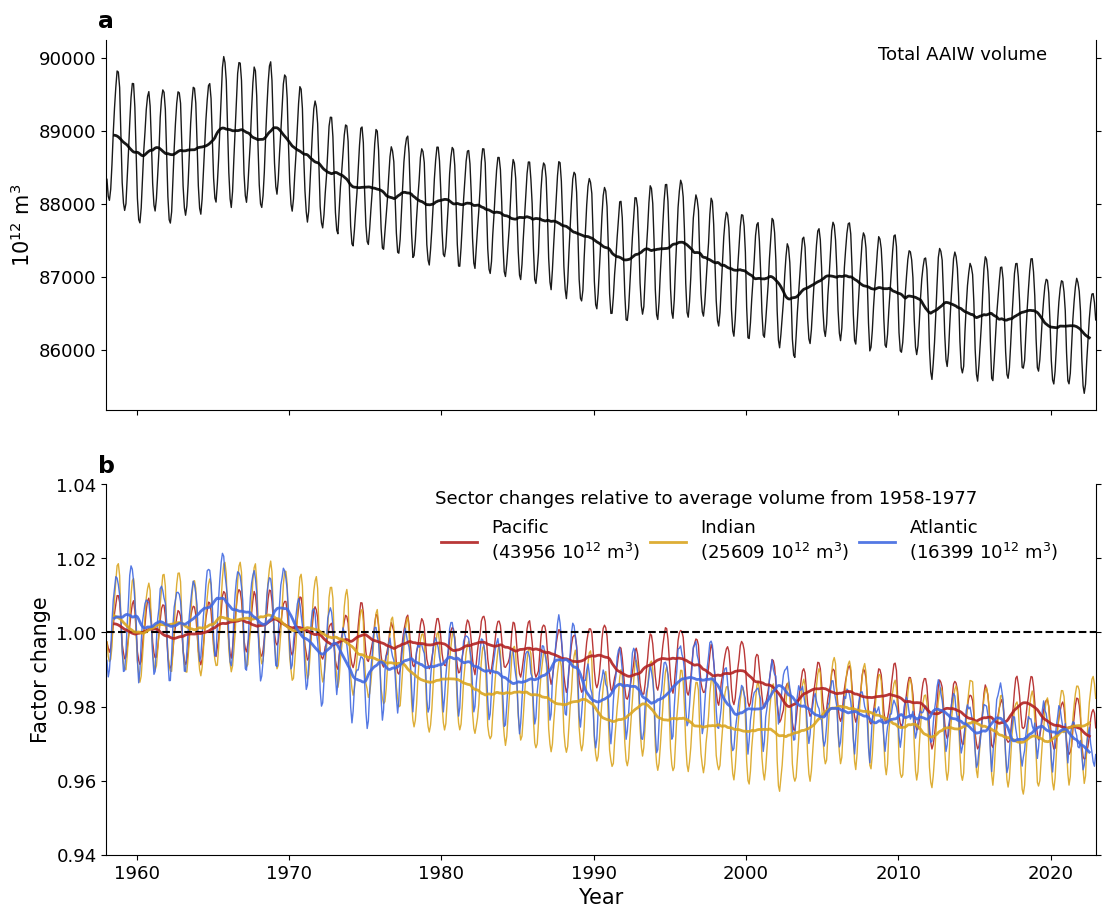

In [17]:
%%time

aaiw_volume = aaiw_lin_volume.compute() * 1
aaiw_volume_pac = aaiw_lin_volume_pac.compute() * 1
aaiw_volume_ind = aaiw_lin_volume_ind.compute() * 1
aaiw_volume_atl = aaiw_lin_volume_atl.compute() * 1

fstic = 13
fslab = 15
lwid = [1.0, 2.0, 2.0, 2.0]
cols = ['k', 'k']
lsty = ['-', '-']
alfs = 0.9
labs = ['Circumpolar', 'Pacific', 'Indian', 'Atlantic']

fig = plt.figure(figsize=(12,10), facecolor='w')
gs = GridSpec(2,1)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.tick_params(right=True, labelsize=fstic, labelbottom=False)
ax2.tick_params(right=True, labelsize=fstic)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.plot(time, aaiw_volume.isel(y=slice(0,72)).sum(dim=['x','y','depth'])*1e-12, color=cols[0], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax1.plot(time, aaiw_volume.isel(y=slice(0,72)).sum(dim=['x','y','depth']).rolling(time=12, center=True).mean()*1e-12, color=cols[1], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1])

aaiw_volume_pac_per = aaiw_volume_pac.isel(y=slice(0,72)).sum(dim=['x','y','depth']) / aaiw_volume_pac.isel(y=slice(0,72),time=slice(0,240)).sum(dim=['x','y','depth']).mean(dim='time')
aaiw_volume_ind_per = aaiw_volume_ind.isel(y=slice(0,72)).sum(dim=['x','y','depth']) / aaiw_volume_ind.isel(y=slice(0,72),time=slice(0,240)).sum(dim=['x','y','depth']).mean(dim='time')
aaiw_volume_atl_per = aaiw_volume_atl.isel(y=slice(0,72)).sum(dim=['x','y','depth']) / aaiw_volume_atl.isel(y=slice(0,72),time=slice(0,240)).sum(dim=['x','y','depth']).mean(dim='time')


cols = ['firebrick', 'goldenrod', 'royalblue']
lab = ['Pacific\n(%d 10$^{12}$ m$^{3}$)'%(aaiw_volume_pac.isel(y=slice(0,72),time=slice(0,240)).sum(dim=['x','y','depth']).mean(dim='time').values*1e-12), \
       'Indian\n(%d 10$^{12}$ m$^{3}$)'%(aaiw_volume_ind.isel(y=slice(0,72),time=slice(0,240)).sum(dim=['x','y','depth']).mean(dim='time').values*1e-12), \
       'Atlantic\n(%d 10$^{12}$ m$^{3}$)'%(aaiw_volume_atl.isel(y=slice(0,72),time=slice(0,240)).sum(dim=['x','y','depth']).mean(dim='time').values*1e-12)]

ax2.plot(time, aaiw_volume_pac_per, color=cols[0], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax2.plot(time, aaiw_volume_ind_per, color=cols[1], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax2.plot(time, aaiw_volume_atl_per, color=cols[2], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])

ax2.plot((time[0],time[-1]),(1,1), 'k--')
ax2.plot(time, aaiw_volume_pac_per.rolling(time=12, center=True).mean(), color=cols[0], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[0])
ax2.plot(time, aaiw_volume_ind_per.rolling(time=12, center=True).mean(), color=cols[1], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[1])
ax2.plot(time, aaiw_volume_atl_per.rolling(time=12, center=True).mean(), color=cols[2], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[2])


ax1.set_xlim(start_date,end_date)
ax2.set_xlim(start_date,end_date)
ax2.set_xlabel("Year", fontsize=fslab)
ax1.set_ylabel("10$^{12}$ m$^{3}$", fontsize=fslab)
ax2.set_ylabel("Factor change", fontsize=fslab)
ax2.legend(loc='upper center', frameon=False, fontsize=fstic, ncol=3, bbox_to_anchor=(0.65,0.95), columnspacing=0.5)

ax1.text(0.95, 0.985,"Total AAIW volume", fontsize=fstic, transform=ax1.transAxes, va='top', ha='right')
ax2.text(0.88, 0.985,"Sector changes relative to average volume from 1958-1977", fontsize=fstic, transform=ax2.transAxes, va='top', ha='right')

plt.subplots_adjust(left=0.1, right=0.925, top=0.925)

ax2.set_ylim(0.94,1.04)

xx = 0.0; yy = 1.05
ax1.text(xx,yy,'a', fontsize=fslab+2, fontweight='bold', va='center', ha='center', transform=ax1.transAxes)
ax2.text(xx,yy,'b', fontsize=fslab+2, fontweight='bold', va='center', ha='center', transform=ax2.transAxes)



In [ ]:
fig.savefig('/home/pbuchanan/analysis_samw/fig-aaiw_lin_volume_timeseries.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-aaiw_lin_volume_timeseries.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-aaiw_lin_volume_timeseries_trans.png', dpi=300, bbox_inches='tight', transparent=True)


## Regrid the model volumes to regular coordinates for plotting

In [20]:
%%time

ds_out = xe.util.grid_global(1,1)

# put time on the first dimension
print("transposing")
samw_cub_volume = samw_cub_volume.transpose("time", "depth", "y", "x")
aaiw_cub_volume = aaiw_cub_volume.transpose("time", "depth", "y", "x")
rho0_cub = rho0_lin.transpose("time", "depth", "y", "x")

# reduce dimensions of datasets to regrid by removing time
print("removing time dimension by averaging")
samw_cub_volume_start = samw_cub_volume.isel(time=slice(0,240)).mean(dim='time')
samw_cub_volume_end = samw_cub_volume.isel(time=slice(-240,780)).mean(dim='time')
aaiw_cub_volume_start = aaiw_cub_volume.isel(time=slice(0,240)).mean(dim='time')
aaiw_cub_volume_end = aaiw_cub_volume.isel(time=slice(-240,780)).mean(dim='time')
rho0_cub_start = rho0_cub.isel(time=slice(0,240)).mean(dim='time')
rho0_cub_end = rho0_cub.isel(time=slice(-240,780)).mean(dim='time')


transposing
removing time dimension by averaging
CPU times: user 28.3 ms, sys: 4.13 ms, total: 32.4 ms
Wall time: 31.9 ms


In [21]:
%%time

ds_in = xr.Dataset(
    {'samw_volume_start': ( ('depth', 'y', 'x'), samw_cub_volume_start.values),
     'samw_volume_end': ( ('depth', 'y', 'x'), samw_cub_volume_end.values),
     'aaiw_volume_start': ( ('depth', 'y', 'x'), aaiw_cub_volume_start.values),
     'aaiw_volume_end': ( ('depth', 'y', 'x'), aaiw_cub_volume_end.values),
     #'rho0_start': ( ('time', 'depth', 'y', 'x'), rho0_lin_start.values),
     #'rho0_end': ( ('time', 'depth', 'y', 'x'), rho0_lin_end.values),
     },
    coords={"lon": (['y','x'], lons.values),
            "lat": (['y','x'], lats.values),
            "depth": (['depth'], samw_cub_volume.coords['depth'].values),
            "time": (['time'], samw_cub_volume.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)



[########################################] | 100% Completed | 10m 6ss
[########################################] | 100% Completed | 599.17 s
[########################################] | 100% Completed | 584.13 s
[########################################] | 100% Completed | 569.57 s
CPU times: user 41min 1s, sys: 21min 17s, total: 1h 2min 19s
Wall time: 39min 22s


In [22]:
%%time

print("Regridding")

samw_volume_start_reg = regridder(ds_in['samw_volume_start'])
samw_volume_end_reg = regridder(ds_in['samw_volume_end'])
aaiw_volume_start_reg = regridder(ds_in['aaiw_volume_start'])
aaiw_volume_end_reg = regridder(ds_in['aaiw_volume_end'])
#rho0_start_reg = regridder(ds_in['rho0_start'])
#rho0_end_reg = regridder(ds_in['rho0_end'])


Regridding
CPU times: user 826 ms, sys: 107 ms, total: 933 ms
Wall time: 941 ms


In [23]:
%%time

print("Preparation for plotting")

### top down
samw_volume_start_area = samw_volume_start_reg.sum(dim='depth')
samw_volume_end_area = samw_volume_end_reg.sum(dim='depth')

### from the front
samw_volume_start_front = samw_volume_start_reg.sum(dim='y')
samw_volume_end_front = samw_volume_end_reg.sum(dim='y')

### from the side of each basin

lons_tmp = samw_volume_start_reg.coords['lon']
lons_tmp = lons_tmp.where(lons_tmp >0.0, other=lons_tmp+360.0)

tmp = samw_volume_start_reg.assign_coords({"lon":lons_tmp})
samw_volume_start_pacside = tmp.where(tmp.coords['lon'] > 140.0, other=0.0).where(tmp.coords['lon'] < 270.0, other=0.0).sum(dim='x')
tmp = samw_volume_end_reg.assign_coords({"lon":lons_tmp})
samw_volume_end_pacside = tmp.where(tmp.coords['lon'] > 140.0, other=0.0).where(tmp.coords['lon'] < 270.0, other=0.0).sum(dim='x')

samw_volume_start_atlside = samw_volume_start_reg.isel(x=slice(110,200)).sum(dim='x')
samw_volume_end_atlside = samw_volume_end_reg.isel(x=slice(110,200)).sum(dim='x')
samw_volume_start_indside = samw_volume_start_reg.isel(x=slice(200,320)).sum(dim='x')
samw_volume_end_indside = samw_volume_end_reg.isel(x=slice(200,320)).sum(dim='x')

### wrap the longitudes for the top-down and from-the-front arrays
samw_volume_start_area = xr.DataArray(
    samw_volume_start_area,
    dims=("y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            }
    )
samw_volume_end_area = xr.DataArray(
    samw_volume_end_area,
    dims=("y", "x"),
    coords={"lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            "lat": (['y'], ds_out.coords['lat'].isel(x=0).values),
            }
    )
samw_volume_start_front = xr.DataArray(
    samw_volume_start_front,
    dims=("depth", "x"),
    coords={"depth": (['depth'], samw_volume_start_front.coords['depth'].values),
            "lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            }
    )
samw_volume_end_front = xr.DataArray(
    samw_volume_end_front,
    dims=("depth", "x"),
    coords={"depth": (['depth'], samw_volume_end_front.coords['depth'].values),
            "lon": (['x'], ds_out.coords['lon'].isel(y=0).values),
            }
    )

samw_volume_start_area_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(samw_volume_start_area, coord=samw_volume_start_area.coords['lon'])
samw_volume_end_area_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(samw_volume_end_area, coord=samw_volume_end_area.coords['lon'])

samw_volume_start_front_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(samw_volume_start_front, coord=samw_volume_start_front.coords['lon'])
samw_volume_end_front_wrapped, lon_reg_wrapped = cutil.add_cyclic_point(samw_volume_end_front, coord=samw_volume_end_front.coords['lon'])




Preparation for plotting
CPU times: user 161 ms, sys: 77.1 ms, total: 238 ms
Wall time: 237 ms


## Figure 2

Text(-0.5, 0.5, '2003-2022\nminus\n1958-1977')

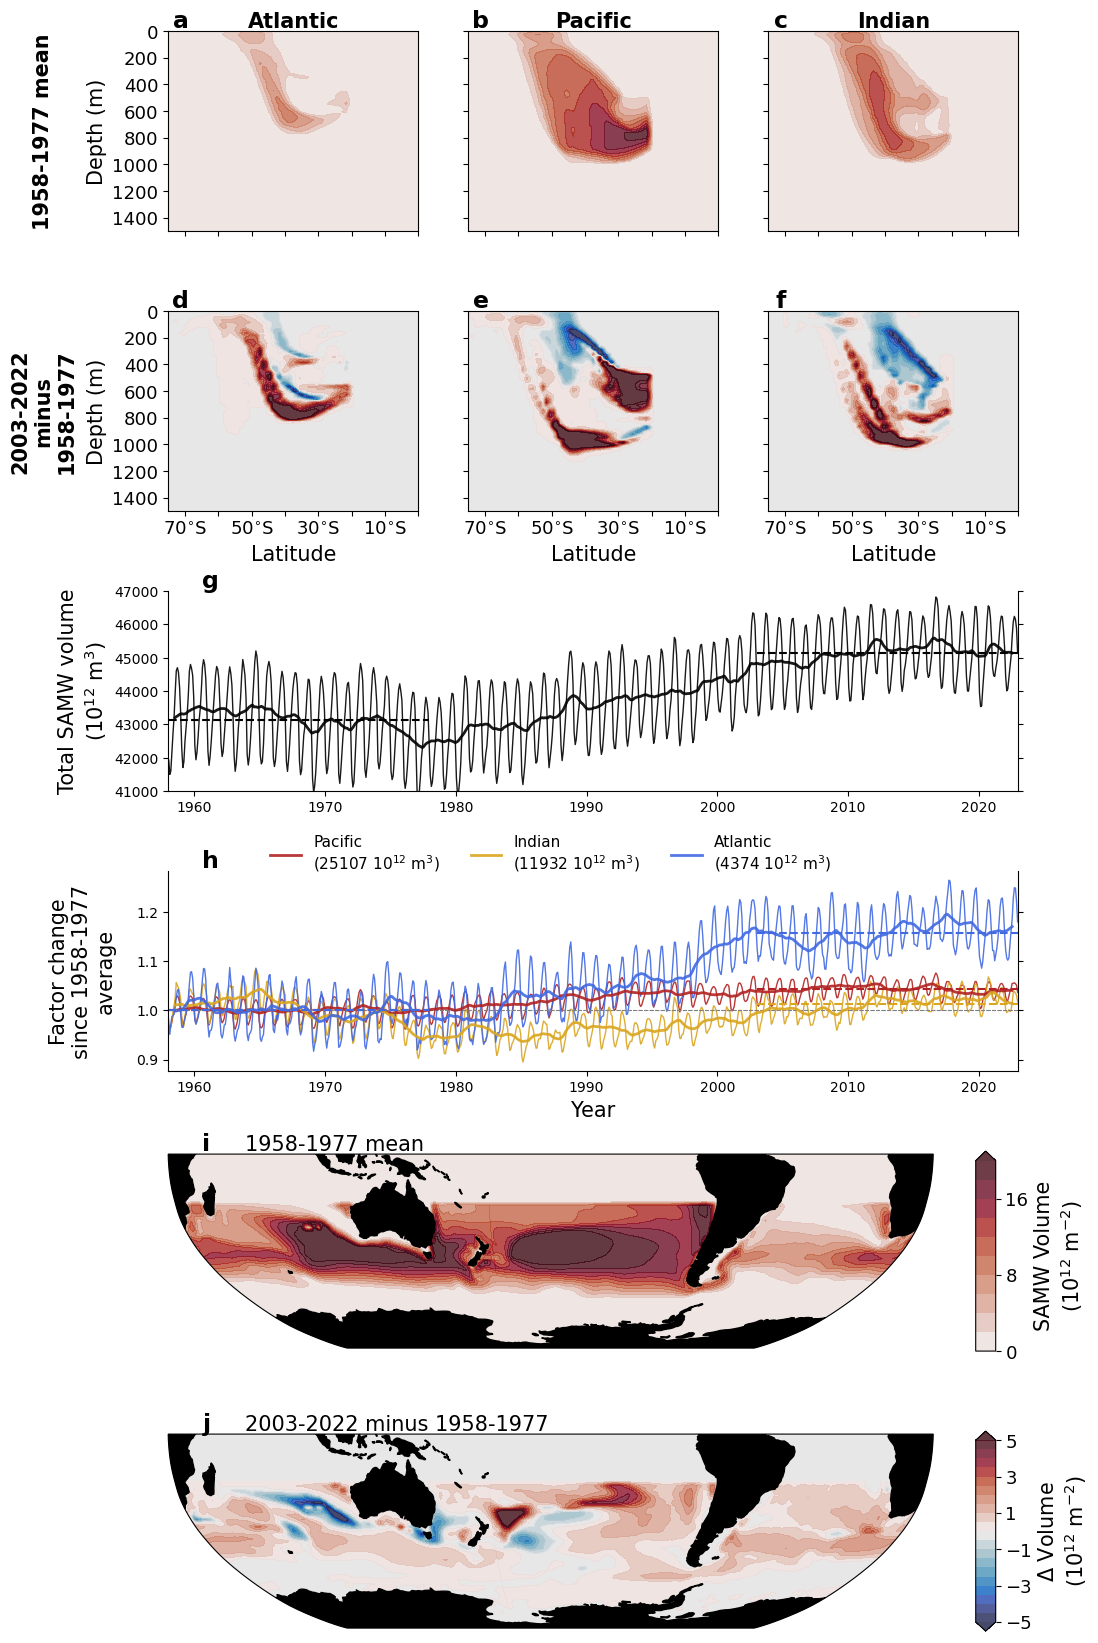

In [35]:

proj = ccrs.Robinson(central_longitude=210)

levs1 = np.arange(0,101,10)
levs2 = np.arange(-10,11,1)
levs9 = np.arange(0,21,2)
levs10 = np.arange(-5,5.1,0.5)

colmap1 = lighten(cmo.amp, 0.8)
colmap2 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15

fig = plt.figure(figsize=(10,20), facecolor='w')
gs = GridSpec(6,3)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
ax7 = plt.subplot(gs[2,:])
ax8 = plt.subplot(gs[3,:])
ax9 = plt.subplot(gs[4,:], projection=proj)
ax10 = plt.subplot(gs[5,:], projection=proj)

ax9.add_feature(cfeature.LAND, zorder=3, color='k')
ax10.add_feature(cfeature.LAND, zorder=3, color='k')
ax9.set_extent([-180,180,-90,0], crs=ccrs.PlateCarree())
ax10.set_extent([-180,180,-90,0], crs=ccrs.PlateCarree())

ax1.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False, labelleft=False)
ax3.tick_params(labelbottom=False, labelleft=False)
ax5.tick_params(labelleft=False)
ax6.tick_params(labelleft=False)
ax7.tick_params(right=True)
ax8.tick_params(right=True)

ax7.spines[['top']].set_visible(False)
ax8.spines[['top']].set_visible(False)

depths = samw_volume_start_atlside.coords['depth']
lats = ds_out['lat'].isel(x=0)

p1 = ax1.contourf(lats, depths, samw_volume_start_atlside * 1e-12, levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='max')
p2 = ax2.contourf(lats, depths, samw_volume_start_pacside * 1e-12, levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='max')
p3 = ax3.contourf(lats, depths, samw_volume_start_indside * 1e-12, levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='max')

p4 = ax4.contourf(lats, depths, (samw_volume_end_atlside - samw_volume_start_atlside) * 1e-12, levels=levs2, cmap=colmap2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')
p5 = ax5.contourf(lats, depths, (samw_volume_end_pacside - samw_volume_start_pacside) * 1e-12, levels=levs2, cmap=colmap2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')
p6 = ax6.contourf(lats, depths, (samw_volume_end_indside - samw_volume_start_indside) * 1e-12, levels=levs2, cmap=colmap2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')

lwid = [1.0, 2.0, 2.0, 2.0]
cols = ['k', 'k']
lsty = ['-', '-']
alfs = 0.9

ax7.plot(time, samw_volume_sum, color=cols[0], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax7.plot(time, samw_volume_sum.rolling(time=12, center=True).mean(), color=cols[1], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1])
ax7.plot(time[0:240], np.ones((240))*samw_volume_sum.isel(time=slice(0,240)).mean(dim='time').values, 'k--')
ax7.plot(time[-240::], np.ones((240))*samw_volume_sum.isel(time=slice(-240,780)).mean(dim='time').values, 'k--')

samw_volume_pac_per = (samw_volume_pac_sum / samw_volume_pac_sum.isel(time=slice(0,240)).mean(dim="time"))
samw_volume_ind_per = (samw_volume_ind_sum / samw_volume_ind_sum.isel(time=slice(0,240)).mean(dim="time"))
samw_volume_atl_per = (samw_volume_atl_sum / samw_volume_atl_sum.isel(time=slice(0,240)).mean(dim="time"))


cols = ['firebrick', 'goldenrod', 'royalblue']
lab = ['Pacific\n(%d 10$^{12}$ m$^{3}$)'%(samw_volume_pac_sum.isel(time=slice(0,240)).mean(dim='time')), \
       'Indian\n(%d 10$^{12}$ m$^{3}$)'%(samw_volume_ind_sum.isel(time=slice(0,240)).mean(dim='time')), \
       'Atlantic\n(%d 10$^{12}$ m$^{3}$)'%(samw_volume_atl_sum.isel(time=slice(0,240)).mean(dim='time'))]

ax8.plot(time, samw_volume_pac_per, color=cols[0], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax8.plot(time, samw_volume_ind_per, color=cols[1], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])
ax8.plot(time, samw_volume_atl_per, color=cols[2], linewidth=lwid[0], alpha=alfs, linestyle=lsty[0])

ax8.plot(time, np.ones(len(time))*samw_volume_pac_per.isel(time=slice(0,240)).mean(dim='time').values, color='grey', linewidth=0.75, alpha=1.0, linestyle='--')
ax8.plot(time, np.ones(len(time))*samw_volume_ind_per.isel(time=slice(0,240)).mean(dim='time').values, color='grey', linewidth=0.75, alpha=1.0, linestyle='--')
ax8.plot(time, np.ones(len(time))*samw_volume_atl_per.isel(time=slice(0,240)).mean(dim='time').values, color='grey', linewidth=0.75, alpha=1.0, linestyle='--')

ax8.plot(time, samw_volume_pac_per.rolling(time=12, center=True).mean(), color=cols[0], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[0])
ax8.plot(time, samw_volume_ind_per.rolling(time=12, center=True).mean(), color=cols[1], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[1])
ax8.plot(time, samw_volume_atl_per.rolling(time=12, center=True).mean(), color=cols[2], linewidth=lwid[1], alpha=alfs, linestyle=lsty[1], label=lab[2])

ax8.plot(time[0:240], np.ones((240))*samw_volume_pac_per.isel(time=slice(0,240)).mean(dim='time').values, linestyle='--', color=cols[0])
ax8.plot(time[-240::], np.ones((240))*samw_volume_pac_per.isel(time=slice(-240,780)).mean(dim='time').values, linestyle='--', color=cols[0])
ax8.plot(time[0:240], np.ones((240))*samw_volume_ind_per.isel(time=slice(0,240)).mean(dim='time').values, linestyle='--', color=cols[1])
ax8.plot(time[-240::], np.ones((240))*samw_volume_ind_per.isel(time=slice(-240,780)).mean(dim='time').values, linestyle='--', color=cols[1])
ax8.plot(time[0:240], np.ones((240))*samw_volume_atl_per.isel(time=slice(0,240)).mean(dim='time').values, linestyle='--', color=cols[2])
ax8.plot(time[-240::], np.ones((240))*samw_volume_atl_per.isel(time=slice(-240,780)).mean(dim='time').values, linestyle='--', color=cols[2])

p9 = ax9.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), samw_volume_start_area_wrapped*1e-12, transform=ccrs.PlateCarree(), levels=levs9, cmap=colmap1, vmin=np.min(levs9), vmax=np.max(levs9), extend='max')
p10 = ax10.contourf(lon_reg_wrapped,ds_out['lat'].isel(x=0), (samw_volume_end_area_wrapped - samw_volume_start_area_wrapped)*1e-12, transform=ccrs.PlateCarree(), levels=levs10, cmap=colmap2, vmin=np.min(levs10), vmax=np.max(levs10), extend='both')


x1 = -75; x2 = 0
y1 = 1500; y2 = 0
ax1.set_xlim(x1,x2); ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2); ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2); ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2); ax4.set_ylim(y1,y2)
ax5.set_xlim(x1,x2); ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2); ax6.set_ylim(y1,y2)

x1 = np.arange(-70,1,10); x2 = np.array(["70$^{\circ}$S", " ", "50$^{\circ}$S", " ", "30$^{\circ}$S", " ", "10$^{\circ}$S", " " ])
y1 = np.arange(1400,-1,-200); y2 = np.arange(1400,-1,-200)
ax1.set_xticks(x1,x2, fontsize=fstic); ax1.set_yticks(y1,y2, fontsize=fstic)
ax2.set_xticks(x1,x2, fontsize=fstic); ax2.set_yticks(y1,y2, fontsize=fstic)
ax3.set_xticks(x1,x2, fontsize=fstic); ax3.set_yticks(y1,y2, fontsize=fstic)
ax4.set_xticks(x1,x2, fontsize=fstic); ax4.set_yticks(y1,y2, fontsize=fstic)
ax5.set_xticks(x1,x2, fontsize=fstic); ax5.set_yticks(y1,y2, fontsize=fstic)
ax6.set_xticks(x1,x2, fontsize=fstic); ax6.set_yticks(y1,y2, fontsize=fstic)

xx = 0.5; yy = 1.05
plt.text(xx,yy,'Atlantic', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'Pacific', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)
plt.text(xx,yy,'Indian', fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax3.transAxes)

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax4.set_ylabel("Depth (m)", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_xlabel("Latitude", fontsize=fslab)
ax6.set_xlabel("Latitude", fontsize=fslab)

ax7.set_xlim(start_date,end_date)
ax8.set_xlim(start_date,end_date)
ax7.set_ylim(41000,47000)

ax8.set_xlabel("Year", fontsize=fslab)
ax7.set_ylabel("Total SAMW volume\n(10$^{12}$ m$^{3}$)", fontsize=fslab)
ax8.set_ylabel("Factor change\nsince 1958-1977\naverage", fontsize=fslab, labelpad=15)
ax8.legend(loc='upper center', frameon=False, fontsize=fstic-2, ncol=3, bbox_to_anchor=(0.45,1.25))


cbar9 = plt.colorbar(p9, ax=ax9, orientation='vertical', ticks=levs9[::4], fraction=0.05, aspect=10, pad=0.05)
cbar10 = plt.colorbar(p10, ax=ax10, orientation='vertical', ticks=levs10[::4], fraction=0.05, aspect=10, pad=0.05)
cbar9.ax.set_ylabel("SAMW Volume\n(10$^{12}$ m$^{-2}$)", fontsize=fslab)
cbar10.ax.set_ylabel("$\Delta$ Volume\n(10$^{12}$ m$^{-2}$)", fontsize=fslab)
cbar9.ax.tick_params(labelsize=fstic)
cbar10.ax.tick_params(labelsize=fstic)

plt.subplots_adjust(left=0.05, top=0.9, bottom=0.1, hspace=0.4)


xx = 0.05; yy = 1.05
plt.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax6.transAxes)
plt.text(xx,yy,'g', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax8.transAxes)
plt.text(xx,yy,'i', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax9.transAxes)
plt.text(xx,yy,'j', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax10.transAxes)

xx = 0.05; yy = 1.05
plt.text(xx*2,yy,"1958-1977 mean", fontsize=fslab, va='center', ha='left', transform=ax9.transAxes)
plt.text(xx*2,yy,"2003-2022 minus 1958-1977", fontsize=fslab, va='center', ha='left', transform=ax10.transAxes)

xx = -0.5; yy = 0.5
plt.text(xx,yy,"1958-1977 mean", fontsize=fslab, va='center', ha='center', fontweight='bold', transform=ax1.transAxes, rotation=90)
plt.text(xx,yy,"2003-2022\nminus\n1958-1977", fontsize=fslab, va='center', fontweight='bold', ha='center', transform=ax4.transAxes, rotation=90)


In [36]:
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_cub_change_20years.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_cub_change_20years.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_cub_change_20years_trans.png', dpi=300, bbox_inches='tight', transparent=True)


### Linear interpolation (Basins)

In [ ]:
%%time

### do the same for the basin-specific waters
samw_lin_volume_pac = samw_lin_volume_pac.transpose("time", "depth", "y", "x")
samw_lin_volume_atl = samw_lin_volume_atl.transpose("time", "depth", "y", "x")
samw_lin_volume_ind = samw_lin_volume_ind.transpose("time", "depth", "y", "x")
aaiw_lin_volume_pac = aaiw_lin_volume_pac.transpose("time", "depth", "y", "x")
aaiw_lin_volume_atl = aaiw_lin_volume_atl.transpose("time", "depth", "y", "x")
aaiw_lin_volume_ind = aaiw_lin_volume_ind.transpose("time", "depth", "y", "x")

### PACIFIC ###
print("Regridding Pacific")
ds_in = xr.Dataset(
    {'samw_lin_volume_pac': ( ('time', 'depth', 'y', 'x'), samw_lin_volume_pac.values),
     'aaiw_lin_volume_pac': ( ('time', 'depth', 'y', 'x'), aaiw_lin_volume_pac.values),
      },
    coords={"lon": (['y','x'], samw_lin_volume_pac.coords['lon'].values),
            "lat": (['y','x'], samw_lin_volume_pac.coords['lat'].values),
            "depth": (['depth'], samw_lin_volume_pac.coords['depth'].values),
            "time": (['time'], samw_lin_volume_pac.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)
samw_lin_volume_pac_reg = regridder(ds_in['samw_lin_volume_pac'])
aaiw_lin_volume_pac_reg = regridder(ds_in['aaiw_lin_volume_pac'])

### INDIAN ###
print("Regridding Indian")
ds_in = xr.Dataset(
    {'samw_lin_volume_ind': ( ('time', 'depth', 'y', 'x'), samw_lin_volume_ind.values),
     'aaiw_lin_volume_ind': ( ('time', 'depth', 'y', 'x'), aaiw_lin_volume_ind.values),
      },
    coords={"lon": (['y','x'], samw_lin_volume_ind.coords['lon'].values),
            "lat": (['y','x'], samw_lin_volume_ind.coords['lat'].values),
            "depth": (['depth'], samw_lin_volume_ind.coords['depth'].values),
            "time": (['time'], samw_lin_volume_ind.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)
samw_lin_volume_ind_reg = regridder(ds_in['samw_lin_volume_ind'])
aaiw_lin_volume_ind_reg = regridder(ds_in['aaiw_lin_volume_ind'])

### ATLANTIC ###
print("Regridding Atlantic")
ds_in = xr.Dataset(
    {'samw_lin_volume_atl': ( ('time', 'depth', 'y', 'x'), samw_lin_volume_atl.values),
     'aaiw_lin_volume_atl': ( ('time', 'depth', 'y', 'x'), aaiw_lin_volume_atl.values),
      },
    coords={"lon": (['y','x'], samw_lin_volume_atl.coords['lon'].values),
            "lat": (['y','x'], samw_lin_volume_atl.coords['lat'].values),
            "depth": (['depth'], samw_lin_volume_atl.coords['depth'].values),
            "time": (['time'], samw_lin_volume_atl.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)
samw_lin_volume_atl_reg = regridder(ds_in['samw_lin_volume_atl'])
aaiw_lin_volume_atl_reg = regridder(ds_in['aaiw_lin_volume_atl'])


### Cubic interpolation (Global)

In [ ]:
%%time

samw_cub_volume = samw_cub_volume.transpose("time", "depth", "y", "x")
aaiw_cub_volume = aaiw_cub_volume.transpose("time", "depth", "y", "x")
rho0_cub = rho0_cub.transpose("time", "depth", "y", "x")

ds_in = xr.Dataset(
    {'samw_cub_volume': ( ('time', 'depth', 'y', 'x'), samw_cub_volume.values),
     'aaiw_cub_volume': ( ('time', 'depth', 'y', 'x'), aaiw_cub_volume.values),
     'rho0_cub': ( ('time', 'depth', 'y', 'x'), rho0_cub.values),
     },
    coords={"lon": (['y','x'], lons.values),
            "lat": (['y','x'], lats.values),
            "depth": (['depth'], samw_lin_volume.coords['depth'].values),
            "time": (['time'], samw_lin_volume.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)

samw_cub_volume_reg = regridder(ds_in['samw_cub_volume'])
aaiw_cub_volume_reg = regridder(ds_in['aaiw_cub_volume'])
rho0_cub_reg = regridder(ds_in['rho0_cub'])


### Cubic interpolation (Basins)

In [ ]:
%%time

samw_cub_volume_pac = samw_cub_volume_pac.transpose("time", "depth", "y", "x")
samw_cub_volume_atl = samw_cub_volume_atl.transpose("time", "depth", "y", "x")
samw_cub_volume_ind = samw_cub_volume_ind.transpose("time", "depth", "y", "x")
aaiw_cub_volume_pac = aaiw_cub_volume_pac.transpose("time", "depth", "y", "x")
aaiw_cub_volume_atl = aaiw_cub_volume_atl.transpose("time", "depth", "y", "x")
aaiw_cub_volume_ind = aaiw_cub_volume_ind.transpose("time", "depth", "y", "x")

### PACIFIC ###
ds_in = xr.Dataset(
    {'samw_cub_volume_pac': ( ('time', 'depth', 'y', 'x'), samw_cub_volume_pac.values),
     'aaiw_cub_volume_pac': ( ('time', 'depth', 'y', 'x'), aaiw_cub_volume_pac.values),
      },
    coords={"lon": (['y','x'], samw_lin_volume_pac.coords['lon'].values),
            "lat": (['y','x'], samw_lin_volume_pac.coords['lat'].values),
            "depth": (['depth'], samw_lin_volume_pac.coords['depth'].values),
            "time": (['time'], samw_lin_volume_pac.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)
samw_cub_volume_pac_reg = regridder(ds_in['samw_cub_volume_pac'])
aaiw_cub_volume_pac_reg = regridder(ds_in['aaiw_cub_volume_pac'])

### INDIAN ###
ds_in = xr.Dataset(
    {'samw_cub_volume_ind': ( ('time', 'depth', 'y', 'x'), samw_cub_volume_ind.values),
     'aaiw_cub_volume_ind': ( ('time', 'depth', 'y', 'x'), aaiw_cub_volume_ind.values),
      },
    coords={"lon": (['y','x'], samw_lin_volume_ind.coords['lon'].values),
            "lat": (['y','x'], samw_lin_volume_ind.coords['lat'].values),
            "depth": (['depth'], samw_lin_volume_ind.coords['depth'].values),
            "time": (['time'], samw_lin_volume_ind.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)
samw_cub_volume_ind_reg = regridder(ds_in['samw_cub_volume_ind'])
aaiw_cub_volume_ind_reg = regridder(ds_in['aaiw_cub_volume_ind'])

### ATLANTIC ###
ds_in = xr.Dataset(
    {'samw_cub_volume_atl': ( ('time', 'depth', 'y', 'x'), samw_cub_volume_atl.values),
     'aaiw_cub_volume_atl': ( ('time', 'depth', 'y', 'x'), aaiw_cub_volume_atl.values),
      },
    coords={"lon": (['y','x'], samw_lin_volume_atl.coords['lon'].values),
            "lat": (['y','x'], samw_lin_volume_atl.coords['lat'].values),
            "depth": (['depth'], samw_lin_volume_atl.coords['depth'].values),
            "time": (['time'], samw_lin_volume_atl.coords['time'].values),
            }
    )
regridder = xe.Regridder(ds_in, ds_out, 'bilinear', ignore_degenerate=True)
samw_cub_volume_atl_reg = regridder(ds_in['samw_cub_volume_atl'])
aaiw_cub_volume_atl_reg = regridder(ds_in['aaiw_cub_volume_atl'])

## what does the volume change look like from above for SAMW?

In [ ]:


lon_reg = ds_out.coords['lon']
lat_reg = ds_out.coords['lat']

proj = ccrs.Robinson(central_longitude=210)

levs1 = np.arange(0,21,2)
levs2 = np.arange(-5,5.1,0.5)
colmap1 = lighten(cmo.amp, 0.8)
colmap2 = lighten(cmo.balance, 0.8)
fstic = 13
fslab = 15

fig = plt.figure(figsize=(12,10), facecolor='w')
gs = GridSpec(2,1)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[1,0], projection=proj)

ax1.add_feature(cfeature.LAND, zorder=3, color='k')
#ax1.add_feature(cfeature.COASTLINE, zorder=3)
ax2.add_feature(cfeature.LAND, zorder=3, color='k')
#ax2.add_feature(cfeature.COASTLINE, zorder=3)
ax1.set_extent([-180,180,-90,0], crs=ccrs.PlateCarree())
ax2.set_extent([-180,180,-90,0], crs=ccrs.PlateCarree())
    
p1 = ax1.contourf(lon_reg,lat_reg, samw_volume_reg.isel(time=slice(0,240)).mean(dim='time').sum(dim='depth') * 1e-12, \
                  transform=ccrs.PlateCarree(), levels=levs1, cmap=colmap1, vmin=np.min(levs1), vmax=np.max(levs1), extend='max')
p2 = ax2.contourf(lon_reg,lat_reg, (samw_volume_reg.isel(time=slice(-240,780)).mean(dim='time').sum(dim='depth') - samw_volume_reg.isel(time=slice(0,240)).mean(dim='time').sum(dim='depth')) * 1e-12, \
                  transform=ccrs.PlateCarree(), levels=levs2, cmap=colmap2, vmin=np.min(levs2), vmax=np.max(levs2), extend='both')

cbar1 = plt.colorbar(p1, ax=ax1, orientation='horizontal', ticks=levs1[::4], fraction=0.075, aspect=20, pad=0.05)
cbar2 = plt.colorbar(p2, ax=ax2, orientation='horizontal', ticks=levs2[::4], fraction=0.075, aspect=20, pad=0.05)

cbar1.ax.set_xlabel("Volume of SAMW (10$^{12}$ m$^{-2}$)", fontsize=fslab)
cbar2.ax.set_xlabel("$\Delta$ Volume (10$^{12}$ m$^{-2}$)", fontsize=fslab)

cbar1.ax.tick_params(labelsize=fstic)
cbar2.ax.tick_params(labelsize=fstic)

plt.subplots_adjust(left=0.05, top=0.9, bottom=0.1, hspace=0.4)


xx = 0.05; yy = 1.05
ax1.text(xx,yy,'a', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
ax2.text(xx,yy,'b', fontsize=fslab+2, va='center', ha='center', fontweight='bold', transform=ax2.transAxes)
ax1.text(xx*2,yy,"1958-1977 mean", fontsize=fslab, va='center', ha='left', transform=ax1.transAxes)
ax2.text(xx*2,yy,"2003-2022 minus 1958-1977", fontsize=fslab, va='center', ha='left', transform=ax2.transAxes)


In [ ]:
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_volume_areachange_20years.png', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_volume_areachange_20years.pdf', dpi=300, bbox_inches='tight')
fig.savefig('/home/pbuchanan/analysis_samw/fig-samw_volume_areachange_20years_trans.png', dpi=300, bbox_inches='tight', transparent=True)

